# 5 The Many Variables & The Spurious Waffles

In [1]:
import math
import os

import arviz as az
import daft
import matplotlib.pyplot as plt
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

/Users/koenrademaker/miniconda3/envs/NUMPYRO/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5.1 Spurious associations

In [2]:
# 5.1
# load data and copy
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce

# standardize
d['A'] = d.MedianAgeMarriage.pipe(lambda x: (x-x.mean())/x.std())
d['D'] = d.Divorce.pipe(lambda x: (x-x.mean())/x.std())

In [3]:
# 5.2
# how big a standard deviation is age at marriage?
d.MedianAgeMarriage.std()

1.2436303013880823

Given a model:

$$D_i ∼ \text{Normal}(μ_i, σ)$$

$$μ_i = α + β_{A}A_{i}$$

$$α ∼ \text{Normal}(0, 0.2) $$

$$β_A ∼ \text{Normal}(0, 0.5) $$

$$σ ∼ \text{Exponential}(1)$$


, when $\beta_{A}$ = 1, and the above std., a change of 1.2 years in median age at marriage ($A_i$) is associated with a full standard deviation change in the outcome variable.

In [4]:
# 5.3
# simulation of priors in the predictive prior distribution

def model(A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), Trace_ELBO(), A=d.A.values, D=d.D.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_1 = svi_result.params

I0000 00:00:1701968095.270261       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|█| 1000/1000 [00:00<00:00, 5824.76it/s, init loss: 2138.6682, avg. loss [95


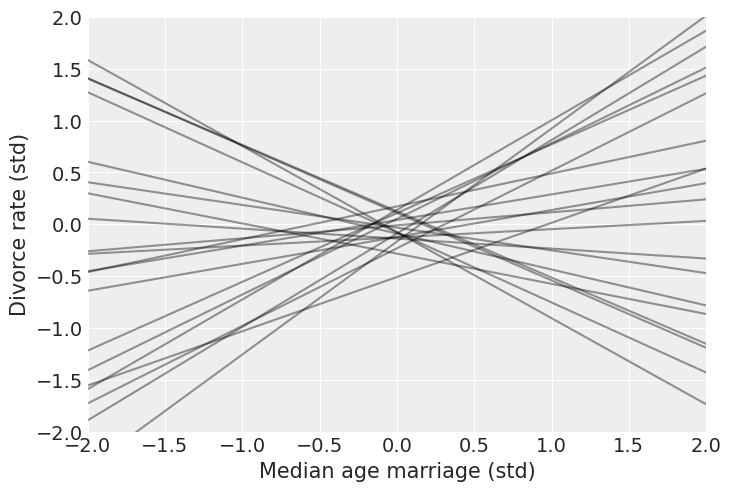

In [5]:
# 5.4
predictive = Predictive(m5_1.model,
                        num_samples=1000,
                        return_sites=['mu'])
prior_pred = predictive(random.PRNGKey(10),
                        A=jnp.array([-2,2]))
mu = prior_pred['mu']

# plot predictive distribution of prior mu
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)
    plt.xlabel('Median age marriage (std)')
    plt.ylabel('Divorce rate (std)')

Note: These are possible predictors for the relationship between median age at marriage and divorce rate from simulations with the priors. Data shown in **Figure 5.2** in the book indicates we expect negative linear relationships, however some priors simulated here would imply a positive linear relationship.

We will simulate some other flatter priors to see how much worse the prior regression lines can become.

100%|█| 1000/1000 [00:00<00:00, 6091.21it/s, init loss: 190.6541, avg. loss [951


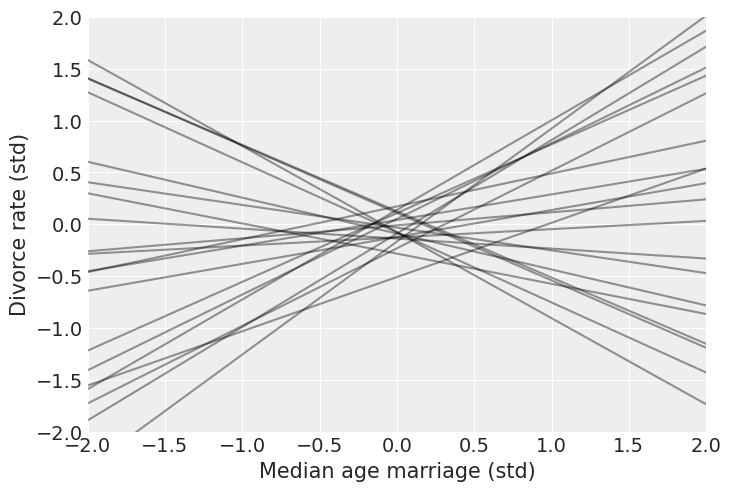

In [6]:
# 5.3
# simulation of priors in the predictive prior distribution

def model(A, D=None):
    a = numpyro.sample('a', dist.Normal(0, 0.2))
    bA = numpyro.sample('b', dist.Normal(4, 3))
    sigma = numpyro.sample('sigma', dist.Uniform(0, 5))
    mu = numpyro.deterministic('mu', a + bA * A)
    numpyro.sample('D', dist.Normal(mu, sigma), obs=D)

m5_1_alt = AutoLaplaceApproximation(model)
svi = SVI(model,
          m5_1_alt,
          optim.Adam(1),
          Trace_ELBO(),
          A=d.A.values,
          D=d.D.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_1_alt = svi_result.params

# 5.4
predictive_alt = Predictive(m5_1_alt.model,
                        num_samples=1000,
                        return_sites=['mu'])
prior_pred_alt = predictive(random.PRNGKey(10),
                        A=jnp.array([-2,2]))
mu_alt = prior_pred['mu']

# plot predictive distribution of prior mu
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)
    plt.xlabel('Median age marriage (std)')
    plt.ylabel('Divorce rate (std)')

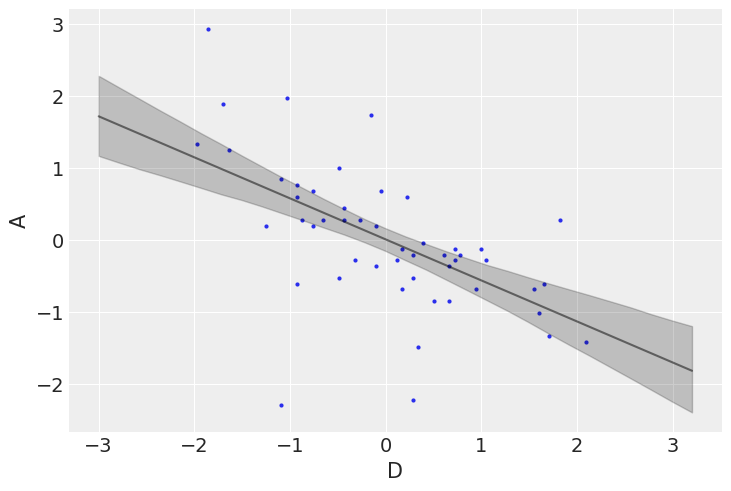

In [7]:
# 5.5
# sample the posterior predictive distribution
A_seq = jnp.linspace(start=-3, stop=3.2, num=30)
post = m5_1.sample_posterior(random.PRNGKey(1), p5_1, (1000,))
post_pred = Predictive(m5_1.model,
                       post)(random.PRNGKey(2), A=A_seq)

# summarise the mean and 89% PI of predicted mu
mu = post_pred['mu']
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5,94.5]), axis=0)

# plot
az.plot_pair(d[['D', 'A']].to_dict(orient='list'))
plt.plot(A_seq, mu_mean, "k", alpha=0.5)
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

100%|█| 1000/1000 [00:00<00:00, 7186.33it/s, init loss: 962.7464, avg. loss [951


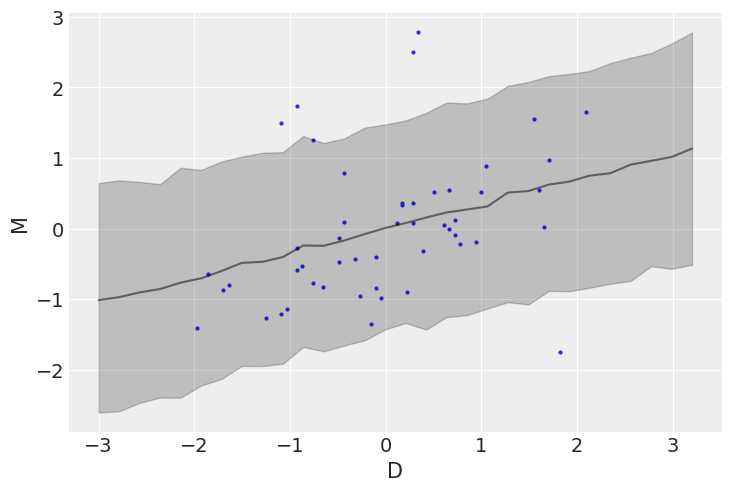

In [8]:
# 5.6
# construct a predictor for divorce rate (D) from marriage rate (M)
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())


def model(M, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), Trace_ELBO(), M=d.M.values, D=d.D.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_2 = svi_result.params


# sample the posterior predictive distribution
M_seq = jnp.linspace(start=-3, stop=3.2, num=30)
post = m5_2.sample_posterior(random.PRNGKey(1), p5_2, (1000,))
post_pred = Predictive(m5_2.model,
                       post)(random.PRNGKey(2), M=M_seq)
post_pred


# summarise the mean and 89% PI of predicted mu
mu = post_pred['D']
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5,94.5]), axis=0)

# plot
az.plot_pair(d[['D', 'M']].to_dict(orient='list'))
plt.plot(A_seq, mu_mean, "k", alpha=0.5)
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

**Overthinking: Drawing a DAG**

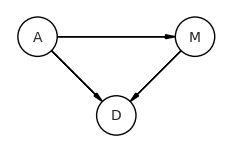

In [9]:
# 5.7
dag5_1 = CausalGraphicalModel(
    nodes = ['A','D','M'],
    edges = [('A','D'), ('A','M'), ('M','D')]
)
# base object for building a graphical model representation
pgm = daft.PGM()

coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()

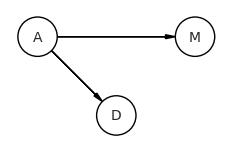

In [10]:
dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()

coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag2.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()

### 5.1.2 Testable implications

“Conditional independencies come in two forms. First, they are statements of which variables should be associated with one another (or not) in the data. Second, they are statements of which variables become dis-associated when we condition on some other set of variables.”

- For the first DAG above, every pair of variables is correlated due to the causal arrows. Therefore, the first **testable implication** is that all three pairs are not independent of each other.
- For the second DAG above, a testable implication is that D is independent of M, conditional on A.
- This thing does not happen for the first DAG above, because conditioning on A does not make DP independent of M.

In [11]:
# 5.8
# return the independencies for the second DAG
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('D', 'M', {'A'})


Above reads as "D \_||#_ M | A"

In [12]:
# 5.9
# return the independencies for the first DAG
DMA_dag2 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

And here, we observe no conditional independencies in the output.

### 5.1.3 Multiple regression notation

To test the implication of the DAGs above, we need a statistical model that conditions on A, so we can see whether it renders D independent of M.

This is where multiple regression comes in, addressing the type of descriptive question as posed here: _"Is there any additional value in knowing a variable, once I already know all of the other predictor variables?"_

Parameter estimates corresponding to each predictor can inform answers to questions of "Does knowing marriage the rate already render knowing age at marriage useful in predicting the divorce rate?" and vice versa.

“(1) Nominate the predictor variables you want in the linear model of the mean.

(2) For each predictor, make a parameter that will measure its association with the outcome.

(3) Multiply the parameter by the variable and add that term to the linear model.”

### 5.1.4 Approximating the posterior

In [13]:
# 5.10
def model(M, A, D=None):
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bM = numpyro.sample('bM', dist.Normal(0,0.5))
    bA = numpyro.sample('bA', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bM * M + bA * A)
    numpyro.sample('D', dist.Normal(mu, sigma), obs=D)

m5_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_3,
    optim.Adam(1),
    Trace_ELBO(),
    M = d.M.values,
    A = d.A.values,
    D=d.D.values
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_3 = svi_result.params

# sample posterior distribution
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, (1000,))

# print summary of parameters
print_summary(post, 0.89, False)

100%|█| 1000/1000 [00:00<00:00, 6390.14it/s, init loss: 3201.7393, avg. loss [95



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.16      0.14   1049.96      1.00
        bA     -0.61      0.16     -0.61     -0.86     -0.35    984.99      1.00
        bM     -0.06      0.16     -0.06     -0.31      0.19    822.38      1.00
     mu[0]      0.37      0.14      0.36      0.15      0.58   1052.80      1.00
     mu[1]      0.32      0.20      0.32      0.02      0.66    917.91      1.00
     mu[2]      0.12      0.10      0.12     -0.04      0.27   1094.94      1.00
     mu[3]      0.76      0.21      0.75      0.43      1.09   1089.30      1.00
     mu[4]     -0.35      0.12     -0.35     -0.53     -0.16    869.88      1.00
     mu[5]      0.12      0.15      0.12     -0.10      0.36    968.97      1.00
     mu[6]     -0.71      0.17     -0.71     -0.98     -0.43    895.70      1.00
     mu[7]     -0.31      0.20     -0.32     -0.65      0.00    860.00      1.00
     mu[8]     -1.74      0

Posterior mean of marriage rate (bM) is close to zero, but spread around to both positive and negative values in the 89% PI.

bA on the other hand is spread within the negative domain by its 89% PI.

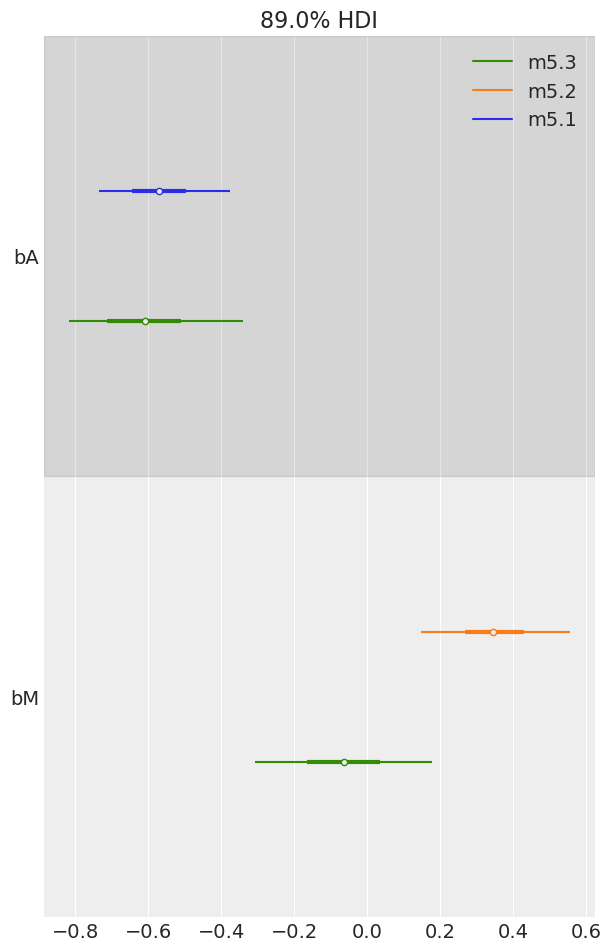

In [14]:
coeftab = {
    "m5.1": m5_1.sample_posterior(
        random.PRNGKey(1),
        p5_1,
        (
            1,
            1000,
        ),
    ),
    "m5.2": m5_2.sample_posterior(
        random.PRNGKey(2),
        p5_2,
        (
            1,
            1000,
        ),
    ),
    "m5.3": m5_3.sample_posterior(
        random.PRNGKey(3),
        p5_3,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bA", "bM"],
    hdi_prob=0.89,
)
plt.show()

We observe that bM has become less informative in model `m5.3`, meaning that bM is only associated with divorce when age at marriage is missing from the model (`m5.2`).

We can interpret this as: Knowing the median age of marriage for a given state, there is little or no additional predictive power in also knowing the rate of marriage in that stage.

#### Overthinking: Simulating the divorce example

In [15]:
# 5.12
N = 50  # number of simulated States
age = dist.Normal().sample(random.PRNGKey(0), sample_shape=(N,))  # sim A
mar = dist.Normal(age).sample(random.PRNGKey(1))  # sim A -> M
div = dist.Normal(age).sample(random.PRNGKey(2))  # sim A -> D

In [16]:
# 5.10
def model(M, A, D=None):
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bM = numpyro.sample('bM', dist.Normal(0,0.5))
    bA = numpyro.sample('bA', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bM * M + bA * A)
    numpyro.sample('D', dist.Normal(mu, sigma), obs=D)

m5_3_sim = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_3_sim,
    optim.Adam(1),
    Trace_ELBO(),
    M = mar,
    A = age,
    D = div
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_3_sim = svi_result.params

# sample posterior distribution
post = m5_3_sim.sample_posterior(random.PRNGKey(1), p5_3_sim, (1000,))

# print summary of parameters
print_summary(post, 0.89, False)

100%|█| 1000/1000 [00:00<00:00, 6560.83it/s, init loss: 2425.0813, avg. loss [95



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.12      0.11      0.11     -0.06      0.28   1049.96      1.00
        bA      0.70      0.16      0.70      0.39      0.92    935.67      1.00
        bM      0.03      0.13      0.03     -0.17      0.25    867.63      1.00
     mu[0]     -0.05      0.17     -0.05     -0.32      0.22    968.09      1.00
     mu[1]     -0.74      0.22     -0.74     -1.09     -0.39   1023.78      1.00
     mu[2]     -0.55      0.17     -0.54     -0.83     -0.30   1089.10      1.00
     mu[3]      0.22      0.12      0.22      0.01      0.39    973.45      1.00
     mu[4]      0.14      0.13      0.14     -0.08      0.35    927.58      1.00
     mu[5]     -0.42      0.15     -0.42     -0.66     -0.19   1108.84      1.00
     mu[6]     -0.43      0.19     -0.43     -0.71     -0.12    970.83      1.00
     mu[7]      0.27      0.27      0.27     -0.17      0.72    818.68      1.00
     mu[8]     -0.03      0

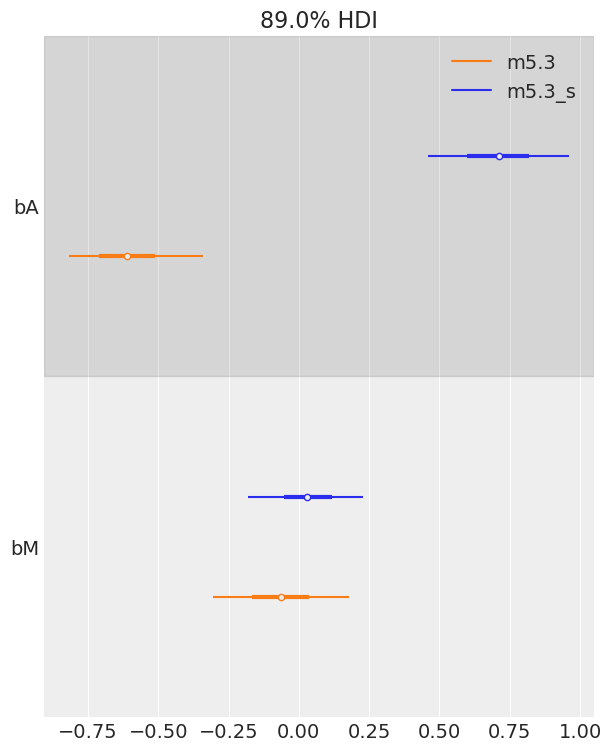

In [17]:
coeftab = {
    "m5.3_s": m5_3_sim.sample_posterior(
        random.PRNGKey(2),
        p5_3_sim,
        (
            1,
            1000,
        ),
    ),
    "m5.3": m5_3.sample_posterior(
        random.PRNGKey(3),
        p5_3,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bA", "bM"],
    hdi_prob=0.89,
)
plt.show()

### 5.1.5 Plotting multivariate posteriors

#### 5.1.5.1 Predictor residual plots

As before, M is marriage rate and A is median age at marriage. Note that since we standardized both variables, we already expect the mean α to be around zero, as before. So I’m reusing the same priors as earlier. This code will approximate the posterior:

In [18]:
# 5.13
def model(A, M=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bAM * A)
    numpyro.sample("M", dist.Normal(mu, sigma), obs=M)


m5_4 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_4, optim.Adam(0.1), Trace_ELBO(), A=d.A.values, M=d.M.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_4 = svi_result.params

100%|█| 1000/1000 [00:00<00:00, 7235.33it/s, init loss: 2288.6685, avg. loss [95


And then we compute the residuals by subtracting the observed marriage rate in each State from the predicted rate, based upon the model above:

In [19]:
# 5.14
post = m5_4.sample_posterior(random.PRNGKey(1), p5_4, (1000,))
post_pred = Predictive(m5_4.model, post)(random.PRNGKey(2), A=d.A.values)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_resid = d.M.values - mu_mean

In [20]:
mu_resid

Array([-0.404817  ,  1.0664229 , -0.09889868,  0.6684858 ,  0.14431378,
        0.6877534 ,  0.06504852,  1.0856906 ,  1.3973002 , -0.632293  ,
        0.4309644 ,  1.7273889 , -0.10458982, -0.05981463, -0.2864678 ,
       -0.00660545, -0.07229406, -0.15779889,  0.03600985, -1.5538536 ,
        0.21325934,  0.22601295, -0.7639445 , -1.1358259 , -0.3622017 ,
       -0.65834904, -0.6287617 , -0.5068812 , -0.4876135 , -0.48463076,
       -0.07256838,  0.4333986 , -0.12848598,  1.3066527 , -0.71454096,
        0.03981543, -0.35568768, -0.63582426, -0.15238237, -0.34265965,
       -0.2633945 , -0.67137706, -0.11844072,  0.95187926, -0.5106868 ,
        0.28926757,  0.24665228, -0.04596376, -0.63555   ,  1.7447712 ],      dtype=float32)

“In simpler terms, States with positive residuals have high marriage rates for their median age of marriage, while States with negative residuals have low rates for their median age of marriage”

#### 5.1.5.2 Posterior prediction plots

Useful to:

- (1) Check if the model correctly approximated the posterior distribution
- (2) Check how the model fails

In [21]:
# 5.15

# Predictive() without new data makes the function use the original (observed) data
post = m5_3.sample_posterior(random.PRNGKey(1),
                             p5_3,
                             (int(1e4),))
post_pred = Predictive(m5_3.model, post)(random.PRNGKey(2), M=d.M.values, A=d.A.values)
mu = post_pred["mu"]

# summarise samples
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5,94.5]), axis=0)

# simulate observation (use original data)
D_sim = post_pred['D']
D_PI = jnp.percentile(D_sim, q=jnp.array([5.5,94.5]), axis=0)

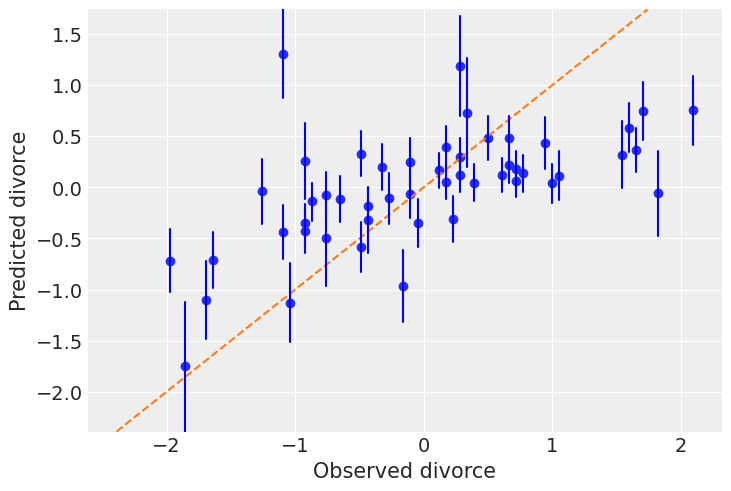

In [22]:
# 5.16
# plot predictions against observed

ax = plt.subplot(
    ylim=(float(mu_PI.min()), float(mu_PI.max())),
    xlabel="Observed divorce",
    ylabel="Predicted divorce",
)
plt.plot(d.D, mu_mean, "o")
x = jnp.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
fig = plt.gcf()

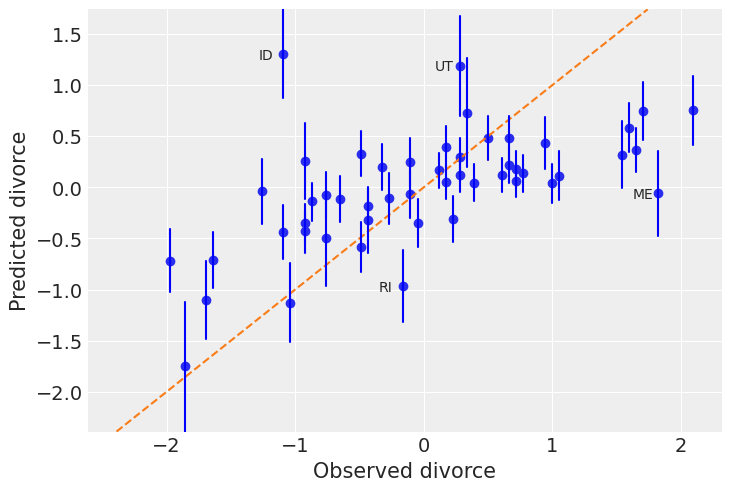

In [23]:
# 5.17
# plot and highlight tricky states for predictions

for i in range(d.shape[0]):
    if d.Loc[i] in ["ID", "UT", "RI", "ME"]:
        ax.annotate(
            d.Loc[i], (d.D[i], mu_mean[i]), xytext=(-25, -5), textcoords="offset pixels"
        )
fig

#### 5.1.5.3 Counterfactual plots

“To estimate the influence of A on M, all we need is to regress A on M, there are no other variables in the DAG creating an association between A and M. We can just add this regression to the quap() model, running two regressions at the same time”

In [2]:
# 5.19
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

In [3]:
def model(A, M=None, D=None):
    # A -> M
    aM = numpyro.sample('aM', dist.Normal(0,0.2))
    bAM = numpyro.sample('bAM', dist.Normal(0,0.5))
    sigma_M = numpyro.sample('sigma_M', dist.Exponential(1))
    mu_M = aM + bAM * A
    M = numpyro.sample('M', dist.Normal(mu_M, sigma_M), obs=M)
    # A -> D <- M
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bM = numpyro.sample('bM', dist.Normal(0,0.5))
    bA = numpyro.sample('bA', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + bM * M + bA * A
    numpyro.sample('D', dist.Normal(mu,sigma), obs=D)

In [4]:
m5_3_A = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_3_A,
    optim.Adam(0.1),
    Trace_ELBO(),
    A = d.A.values,
    M = d.M.values,
    D = d.D.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_3_A = svi_result.params

I0000 00:00:1702472676.688356       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|█| 1000/1000 [00:00<00:00, 3678.06it/s, init loss: 10480.9570, avg. loss [9


Look at the model summary to understand the association between M and A.

In [5]:
post = m5_3_A.sample_posterior(random.PRNGKey(1), p5_3_A, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.16      0.15    853.86      1.00
        aM     -0.00      0.09      0.00     -0.14      0.14    983.38      1.00
        bA     -0.60      0.16     -0.61     -0.84     -0.33   1002.25      1.00
       bAM     -0.69      0.10     -0.69     -0.84     -0.54   1023.78      1.00
        bM     -0.05      0.16     -0.05     -0.31      0.20   1014.77      1.00
     sigma      0.80      0.08      0.80      0.68      0.93   1012.07      1.00
   sigma_M      0.69      0.07      0.69      0.57      0.79   1027.73      1.00



What happens if we manipulate A for a given range of values?

In [6]:
# 5.20
A_seq = jnp.linspace(-2, 2, num=30)
A_seq

Array([-2.        , -1.8620689 , -1.724138  , -1.5862069 , -1.4482758 ,
       -1.3103449 , -1.1724138 , -1.0344827 , -0.89655167, -0.75862074,
       -0.62068963, -0.48275858, -0.34482765, -0.20689654, -0.06896549,
        0.06896549,  0.20689654,  0.3448276 ,  0.48275858,  0.62068963,
        0.75862074,  0.89655167,  1.0344827 ,  1.1724138 ,  1.3103447 ,
        1.4482758 ,  1.5862069 ,  1.724138  ,  1.8620689 ,  2.        ],      dtype=float32)

Next, we want to simulate values of M and D (in that order). To follow our causal assumptions (that we want to test), we first generate M from A to simulate the influence of A, before simulating the influence of A and M on D.

In [10]:
# prep data
sim_dat = dict(A=A_seq)

# simulate M and then D, using simulated data
post = m5_3_A.sample_posterior(random.PRNGKey(1), p5_3_A, (1000,))
s = Predictive(m5_3_A.model, post)(random.PRNGKey(2), **sim_dat)

Plotting the predictions

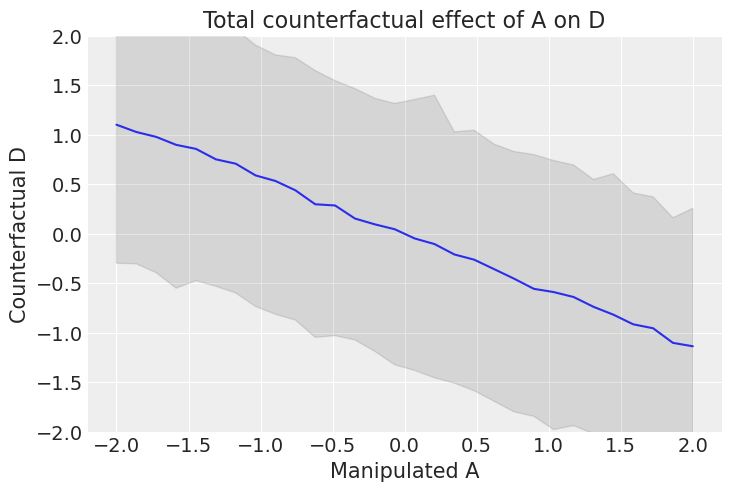

In [12]:
# 5.22
plt.plot(sim_dat['A'], jnp.mean(s['D'], 0))
plt.gca().set(ylim=(-2,2),xlabel='Manipulated A',ylabel='Counterfactual D')
plt.fill_between(
    sim_dat['A'],
    *jnp.percentile(s['D'], q=jnp.array([5.5,94.5]), axis=0),
    color='k',
    alpha=0.1
)
plt.title("Total counterfactual effect of A on D")
plt.show()

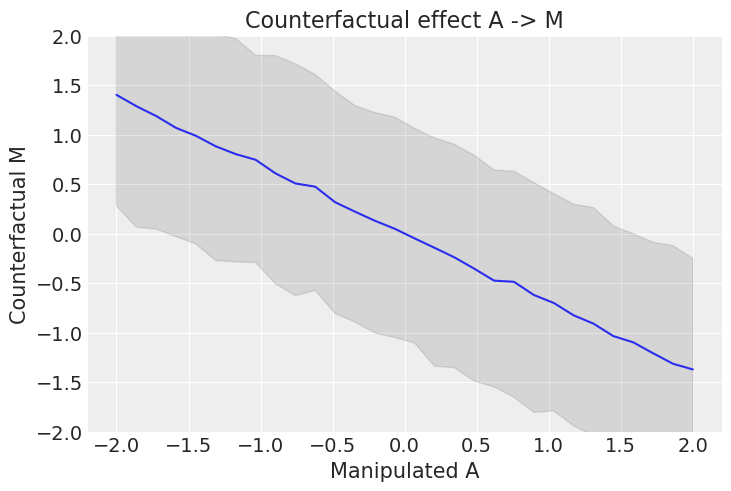

In [13]:
# 5.22 (adapted to generate Counterfactual effect A > M
plt.plot(sim_dat['A'], jnp.mean(s['M'], 0))
plt.gca().set(ylim=(-2,2),xlabel='Manipulated A',ylabel='Counterfactual M')
plt.fill_between(
    sim_dat['A'],
    *jnp.percentile(s['M'], q=jnp.array([5.5,94.5]), axis=0),
    color='k',
    alpha=0.1
)
plt.title("Counterfactual effect A -> M")
plt.show()

Simulate the counterfactual result of manipulating M. We’ll simulate a counterfactual for an average state, with A = 0, and see what changing M does.

In [15]:
# 5.23
d.MedianAgeMarriage.mean()
d.MedianAgeMarriage.std()

sim2_dat = dict(A=(jnp.array([20, 30]) - 26.1) / 1.24)
s2 = Predictive(m5_3_A.model, post, return_sites=["M", "D"])(
    random.PRNGKey(2), **sim2_dat
)
jnp.mean(s2["D"][:, 1] - s2["D"][:, 0])

Array(-4.632526, dtype=float32)

#### Overthinking: Simulating counterfactuals

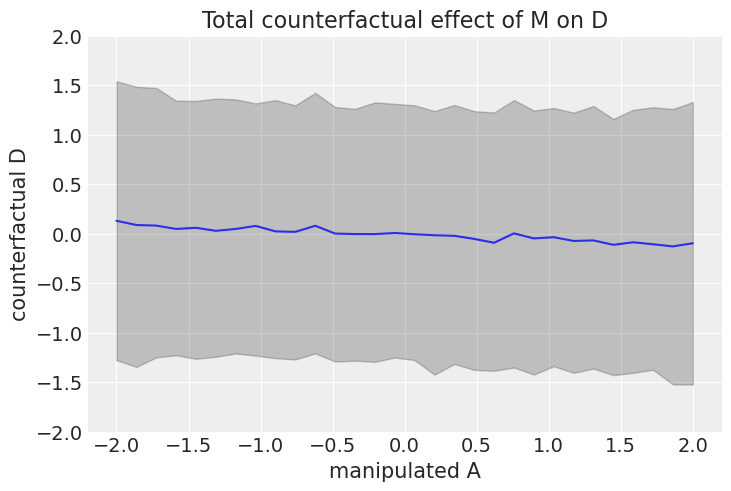

In [16]:
# 5.24
sim_dat = dict(M=jnp.linspace(-2,2,num=30),
               A=0)
s = Predictive(m5_3_A.model, post)(random.PRNGKey(2), **sim_dat)['D']

plt.plot(sim_dat["M"], jnp.mean(s, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(
    sim_dat["M"],
    *jnp.percentile(s, q=jnp.array([5.5, 94.5]), axis=0),
    color="k",
    alpha=0.2
)
plt.title("Total counterfactual effect of M on D")
plt.show()

In [17]:
# 5.25
A_seq = jnp.linspace(-2,2,num=30)

In [18]:
# 5.26
post = m5_3_A.sample_posterior(random.PRNGKey(1), p5_3_A, (1000,))
post = {k: v[..., None] for k, v in post.items()}
M_sim = dist.Normal(post["aM"] + post["bAM"] * A_seq).sample(random.PRNGKey(1))

If you plot A_seq against the column means of D_sim, you’ll see the same result as before. In complex models, there might be many more variables to simulate. But the basic procedure is the same.

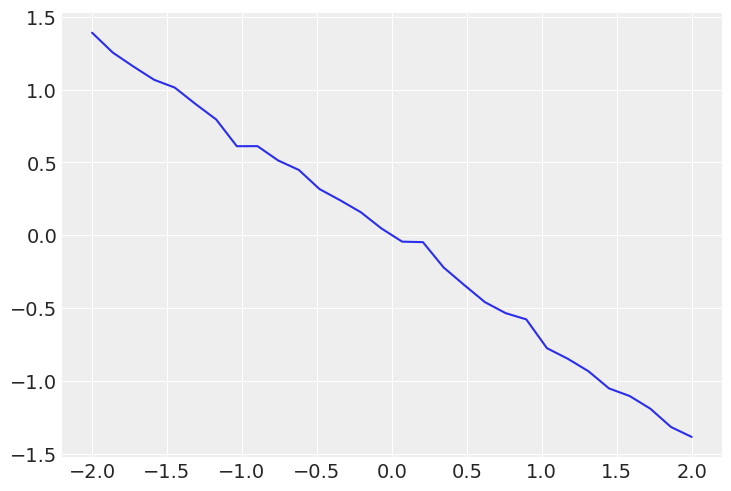

In [23]:
plt.plot(A_seq, jnp.mean(M_sim, 0))

## 5.2 Masked relationship

In [24]:
# 5.28
milk = pd.read_csv('../data/milk.csv', sep=';')
d = milk
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


Standardize to get reliable approximations of the posterior as well as build reasonable priors.

In [26]:
# 5.28
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["N"] = d["neocortex.perc"].pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.mass.map(math.log).pipe(lambda x: (x - x.mean()) / x.std())

In [31]:
# 5.30
def model(N, K):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bN = numpyro.sample("bN", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


with numpyro.validation_enabled():
    try:
        m5_5_draft = AutoLaplaceApproximation(model)
        svi = SVI(
            model, m5_5_draft, optim.Adam(1), Trace_ELBO(), N=d.N.values, K=d.K.values
        )
        svi_result = svi.run(random.PRNGKey(0), 1000)
        p5_5_draft = svi_result.params
    except ValueError as e:
        print(str(e))

Normal distribution got invalid loc parameter.


In [32]:
# 5.30
d['neocortex.perc']

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

In [33]:
# 5.31
dcc = d.iloc[d[['K','N','M']].dropna(how='any',axis=0).index]

In [35]:
dcc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 0 to 28
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           17 non-null     object 
 1   species         17 non-null     object 
 2   kcal.per.g      17 non-null     float64
 3   perc.fat        17 non-null     float64
 4   perc.protein    17 non-null     float64
 5   perc.lactose    17 non-null     float64
 6   mass            17 non-null     float64
 7   neocortex.perc  17 non-null     float64
 8   K               17 non-null     float64
 9   N               17 non-null     float64
 10  M               17 non-null     float64
dtypes: float64(9), object(2)
memory usage: 1.6+ KB


$$K_i \sim \text{Normal}(\mu_i, \sigma_i)$$

$$\mu_i = \alpha + \beta_N N_i$$

In [37]:
# 5.32
def model(N, K=None):
    a = numpyro.sample('a', dist.Normal(0,1))
    bN = numpyro.sample('bN', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bN * N)
    numpyro.sample('K', dist.Normal(mu, sigma), obs=K)

m5_5_draft = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_5_draft,
    optim.Adam(0.1),
    Trace_ELBO(),
    N=dcc.N.values,
    K=dcc.K.values
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_5_draft = svi_result.params  

100%|█| 1000/1000 [00:00<00:00, 7063.19it/s, init loss: 411.1621, avg. loss [951


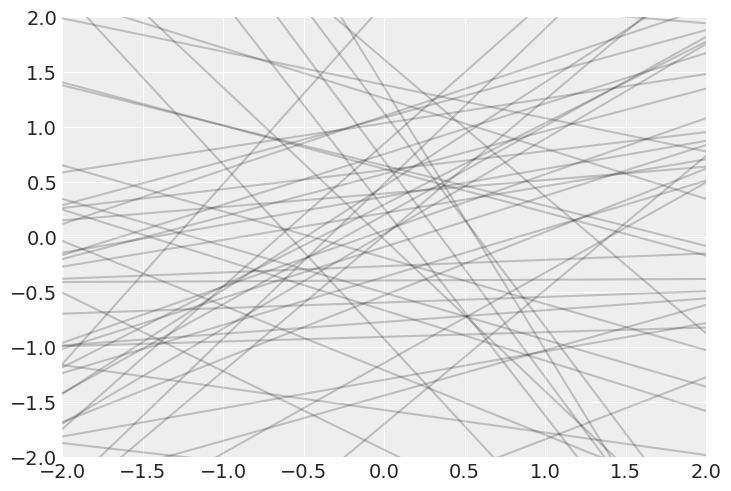

In [40]:
# 5.33
# Sample Posterior Predictive Distribution to assess current priors
xseq = jnp.array([-2,2])
prior_pred = Predictive(model,
                        num_samples=1000)(random.PRNGKey(1), N=xseq)
mu = prior_pred['mu']
plt.subplot(xlim=xseq,ylim=xseq)
for i in range(50):
    plt.plot(xseq, mu[i], 'k', alpha=0.2)

<Axes: >

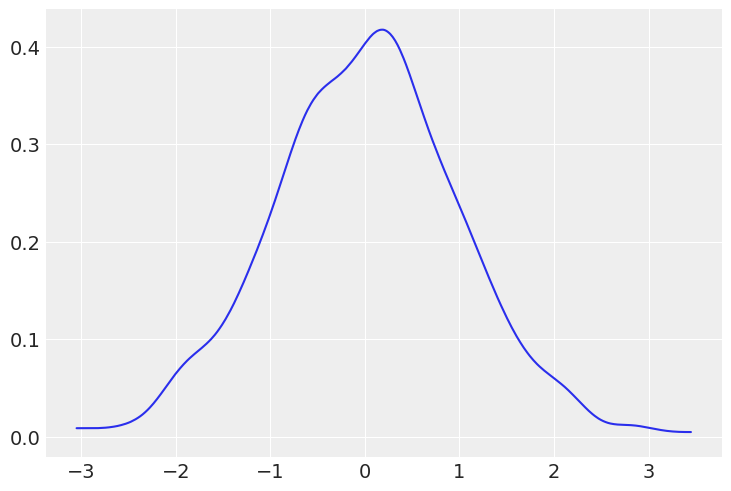

In [47]:
az.plot_kde(prior_pred['a'])

we can do better by both tightening the $\alpha$ prior so that it sticks closer to zero. With two standardized variables, when predictor is zero, the expected value of the outcome should also be zero. And the slope $\beta_N$ needs to be a bit tighter as well, so that it doesn’t regularly produce impossibly strong relationships.

In [48]:
# 5.34
# 5.32
def model(N, K=None):
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bN = numpyro.sample('bN', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bN * N)
    numpyro.sample('K', dist.Normal(mu, sigma), obs=K)

m5_5 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_5,
    optim.Adam(0.1),
    Trace_ELBO(),
    N=dcc.N.values,
    K=dcc.K.values
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_5 = svi_result.params  

100%|█| 1000/1000 [00:00<00:00, 6048.62it/s, init loss: 414.1050, avg. loss [951


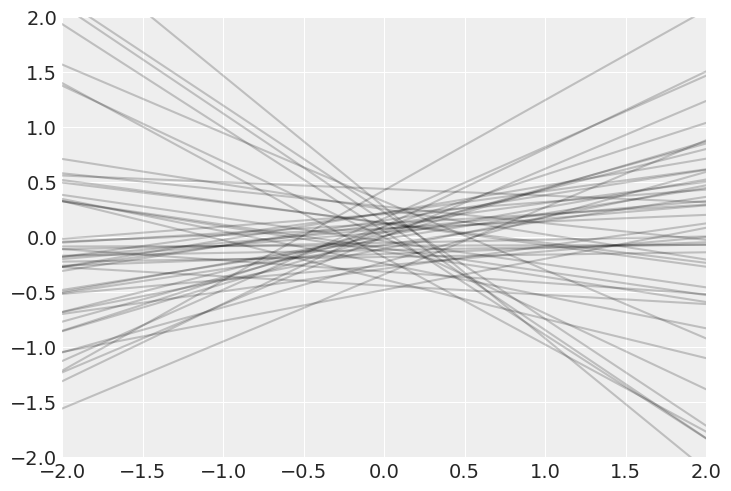

In [49]:
# Repeat sampling the Posterior Predictive Distribution to assess updated priors
xseq = jnp.array([-2,2])
prior_pred = Predictive(model,
                        num_samples=1000)(random.PRNGKey(1), N=xseq)
mu = prior_pred['mu']
plt.subplot(xlim=xseq,ylim=xseq)
for i in range(50):
    plt.plot(xseq, mu[i], 'k', alpha=0.2)

In [50]:
# 5.35
# Inspect posterior distribution parameters
post = m5_5.sample_posterior(random.PRNGKey(1), p5_5, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.05      0.16      0.05     -0.21      0.29    931.50      1.00
        bN      0.13      0.23      0.13     -0.21      0.53   1111.88      1.00
     mu[0]     -0.22      0.51     -0.22     -0.99      0.60    911.65      1.00
     mu[1]     -0.02      0.20     -0.01     -0.36      0.27    906.66      1.00
     mu[2]     -0.02      0.20     -0.01     -0.36      0.27    906.66      1.00
     mu[3]      0.05      0.16      0.05     -0.21      0.29    931.28      1.00
     mu[4]      0.08      0.17      0.08     -0.18      0.36    940.50      1.00
     mu[5]     -0.14      0.38     -0.13     -0.74      0.45    889.84      1.00
     mu[6]     -0.08      0.28     -0.07     -0.52      0.36    874.50      1.00
     mu[7]     -0.11      0.33     -0.10     -0.65      0.37    884.63      1.00
     mu[8]      0.10      0.18      0.10     -0.18      0.41    964.72      1.00
     mu[9]      0.11      0

plot the predicted mean and 89% compatibility interval for the mean

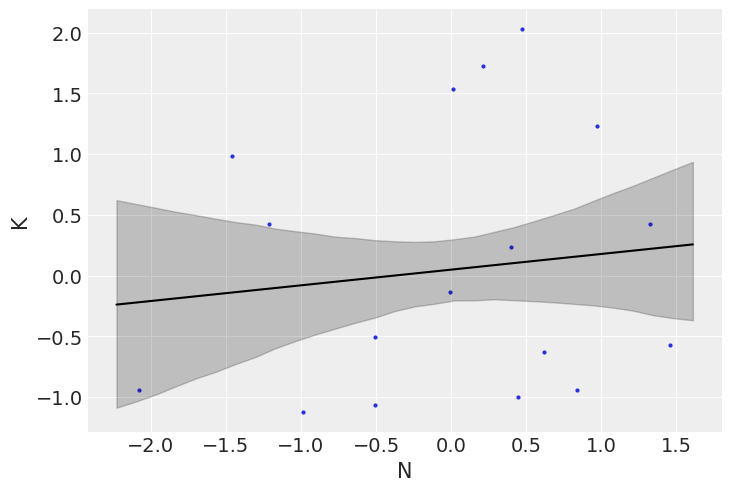

In [54]:
# 5.36
# sequence of data points for Neocortex.perc
xseq = jnp.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
# sample posterior distribution
post = m5_5.sample_posterior(random.PRNGKey(1), p5_5, (1000,))
# sample posterior predictive distribution
post_pred = Predictive(m5_5.model, post)(random.PRNGKey(2), N=xseq)
# get mean and 89% PI of predicted mean
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
# plot
az.plot_pair(dcc[["N", "K"]].to_dict(orient="list"))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

In [55]:
# 5.37
def model(M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_6, optim.Adam(1), Trace_ELBO(), M=dcc.M.values, K=dcc.K.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_6 = svi_result.params
post = m5_6.sample_posterior(random.PRNGKey(1), p5_6, (1000,))
print_summary(post, 0.89, False)

100%|█| 1000/1000 [00:00<00:00, 6247.19it/s, init loss: 756.0300, avg. loss [951



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.16      0.06     -0.20      0.29    931.50      1.00
        bM     -0.28      0.20     -0.28     -0.61      0.03   1088.44      1.00
     mu[0]      0.18      0.18      0.19     -0.11      0.47    944.38      1.00
     mu[1]      0.02      0.16      0.02     -0.24      0.26    932.90      1.00
     mu[2]      0.02      0.16      0.02     -0.24      0.26    933.51      1.00
     mu[3]      0.14      0.17      0.15     -0.11      0.42    958.01      1.00
     mu[4]      0.36      0.27      0.36     -0.07      0.78    872.95      1.00
     mu[5]      0.65      0.45      0.65     -0.03      1.39    898.90      1.00
     mu[6]      0.42      0.31      0.43     -0.07      0.89    878.58      1.00
     mu[7]      0.49      0.35      0.50     -0.09      1.00    885.51      1.00
     mu[8]      0.22      0.20      0.23     -0.12      0.51    906.05      1.00
     mu[9]      0.10      0

Now, using log(mass) as predictor instead of neocortex percentage, we find a negative correlation with the outcome variable ($bM = -0.28$) while this was positive for N ($bN = 0.13$)

Repeat plotting the mean and 89% PI of mean sampled posterior outcome variable results for bM

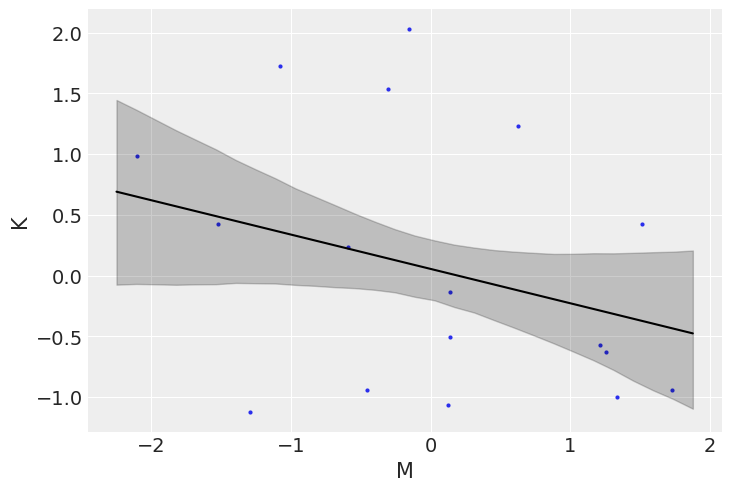

In [58]:
xseq = jnp.linspace(start=dcc.M.min() - 0.15, stop=dcc.M.max() + 0.15, num=30)
# sample posterior distribution
post = m5_6.sample_posterior(random.PRNGKey(1), p5_6, (1000,))
# sample posterior predictive distribution
post_pred = Predictive(m5_6.model, post)(random.PRNGKey(2), M=xseq)
# get mean and 89% PI of predicted mean
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
# plot
az.plot_pair(dcc[["M", "K"]].to_dict(orient="list"))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

Now let’s see what happens when we add both predictor variables at the same time to the regression. This is the multivariate model, in math form:

$K_i \sim \text{Normal}(\mu_i, \sigma)$

$μ_i = α + β_NN_i + β_MM_i $

$α \sim \text{Normal}(0, 0.2) $

$β_n \sim \text{Normal}(0, 0.5) $

$β_m \sim \text{Normal}(0, 0.5)$

$σ \sim \text{Exponential}(1)$

In [76]:
# 5.38
def model(N, M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


m5_7 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_7,
    optim.Adam(1),
    Trace_ELBO(),
    N=dcc.N.values,
    M=dcc.M.values,
    K=dcc.K.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_7 = svi_result.params
post = m5_7.sample_posterior(random.PRNGKey(1), p5_7, (1000,))
print_summary(post, 0.89, False)

100%|█| 1000/1000 [00:00<00:00, 5434.97it/s, init loss: 136.3944, avg. loss [951



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.13      0.06     -0.15      0.26   1049.96      1.00
        bM     -0.69      0.23     -0.69     -1.05     -0.32    887.31      1.00
        bN      0.67      0.26      0.67      0.24      1.09    810.77      1.00
     mu[0]     -1.01      0.49     -1.02     -1.88     -0.31    903.36      1.00
     mu[1]     -0.36      0.20     -0.36     -0.67     -0.04    892.91      1.00
     mu[2]     -0.37      0.20     -0.37     -0.68     -0.05    890.73      1.00
     mu[3]      0.28      0.15      0.28      0.03      0.52   1132.15      1.00
     mu[4]      0.95      0.32      0.96      0.50      1.50    979.70      1.00
     mu[5]      0.54      0.38      0.53     -0.10      1.09   1065.64      1.00
     mu[6]      0.30      0.26      0.30     -0.11      0.69   1075.27      1.00
     mu[7]      0.30      0.30      0.30     -0.15      0.77   1062.82      1.00
     mu[8]      0.74      0

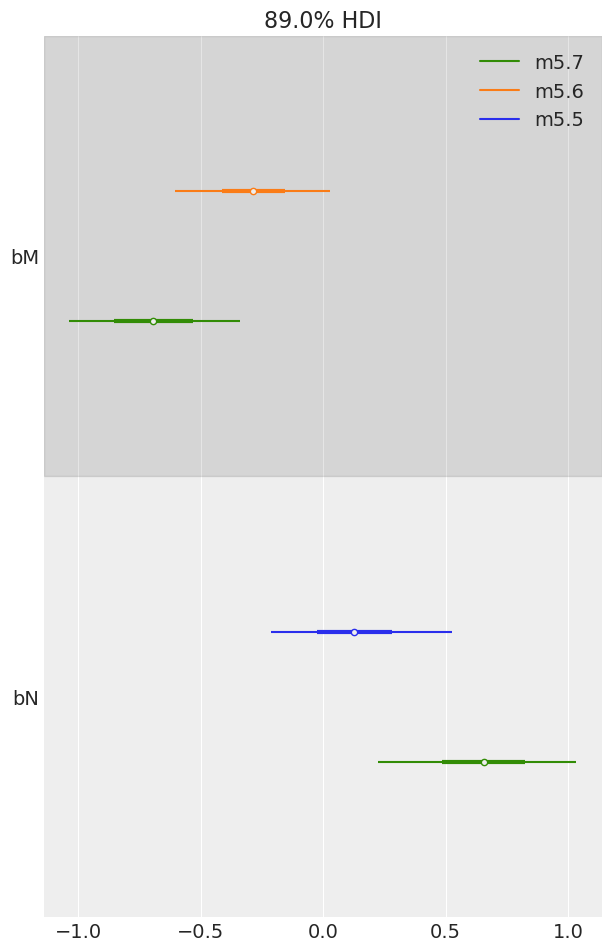

In [77]:
# 5.39
coeftab = {
    "m5.5": m5_5.sample_posterior(
        random.PRNGKey(1),
        p5_5,
        (
            1,
            1000,
        ),
    ),
    "m5.6": m5_6.sample_posterior(
        random.PRNGKey(2),
        p5_6,
        (
            1,
            1000,
        ),
    ),
    "m5.7": m5_7.sample_posterior(
        random.PRNGKey(3),
        p5_7,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bM", "bN"],
    hdi_prob=0.89,
)
plt.show()

you can sample from the prior predictive::

    predictive = Predictive(model, num_samples=1000)
    y_pred = predictive(rng_key, X)["obs"]

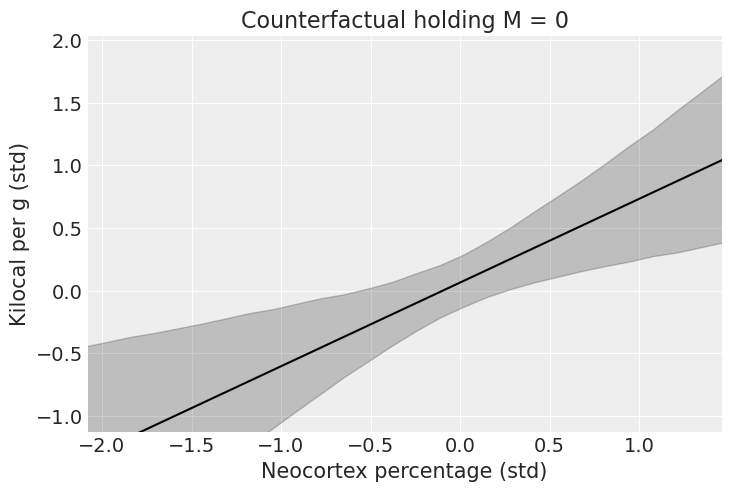

In [87]:
# 5.40
# sequence points for N
xseq = jnp.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)

# sample posterior and predictive posterior distribution (counterfactual by setting M=0)
post = m5_7.sample_posterior(random.PRNGKey(1), p5_7, (1000,))
post_pred = Predictive(m5_7.model, post)(random.PRNGKey(2), M=0, N=xseq)

# summarise mean and 89% PI
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

# plot
plt.subplot(xlim=(dcc.N.min(), dcc.N.max()), ylim=(dcc.K.min(), dcc.K.max()))
plt.plot(xseq, mu_mean, "k")
plt.ylabel('Kilocal per g (std)')
plt.xlabel('Neocortex percentage (std)')
plt.title('Counterfactual holding M = 0')
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

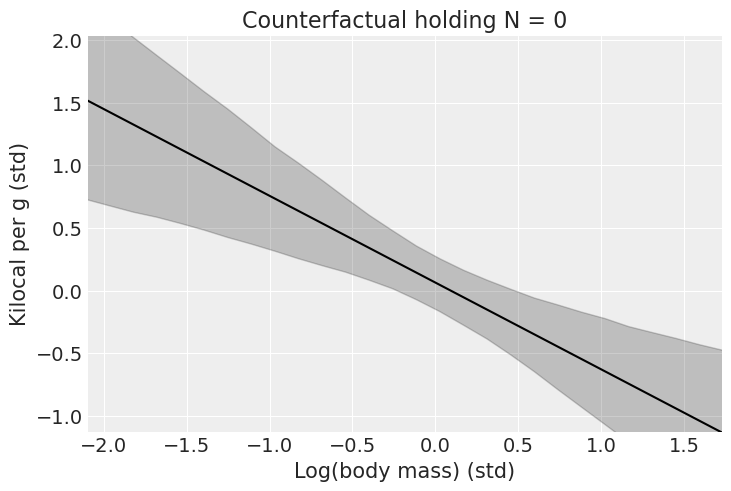

In [88]:
# 5.40
# sequence points for M
xseq = jnp.linspace(start=dcc.M.min() - 0.15, stop=dcc.M.max() + 0.15, num=30)

# sample posterior and predictive posterior distribution (counterfactual by setting N=0)
post = m5_7.sample_posterior(random.PRNGKey(1), p5_7, (1000,))
post_pred = Predictive(m5_7.model, post)(random.PRNGKey(2), N=0, M=xseq)

# summarise mean and 89% PI
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

# plot
plt.subplot(xlim=(dcc.M.min(), dcc.M.max()), ylim=(dcc.K.min(), dcc.K.max()))
plt.plot(xseq, mu_mean, "k")
plt.ylabel('Kilocal per g (std)')
plt.xlabel('Log(body mass) (std)')
plt.title('Counterfactual holding N = 0')
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

#### Overthinking: Simulating a masking relationship

Simulate data according to DAG:
- M > K < N
- M > N

100%|█| 1000/1000 [00:00<00:00, 5586.80it/s, init loss: 2939.4739, avg. loss [95
100%|█| 1000/1000 [00:00<00:00, 6817.88it/s, init loss: 3547.5972, avg. loss [95
100%|█| 1000/1000 [00:00<00:00, 5834.51it/s, init loss: 1521.8649, avg. loss [95


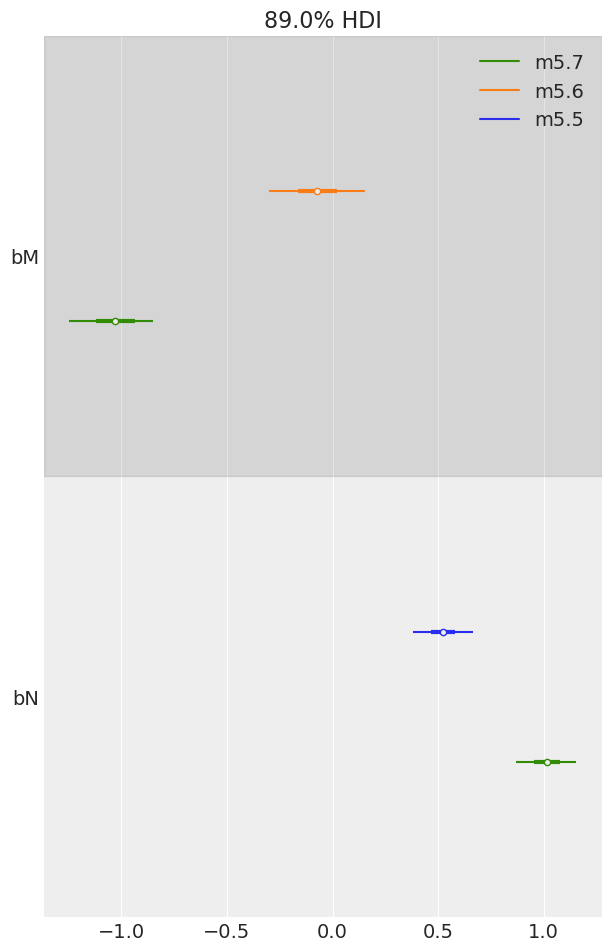

In [114]:
# M -> K <- N
# M -> N
n = 100
M = dist.Normal().sample(random.PRNGKey(0), (n,))
N = dist.Normal(M).sample(random.PRNGKey(1))
K = dist.Normal(N - M).sample(random.PRNGKey(2))
d_sim = pd.DataFrame({"K": K, "N": N, "M": M})

#------------------------------------------------------------#

# Recreate m5_5_sim
def model(N, K=None):
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bN = numpyro.sample('bN', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bN * N)
    numpyro.sample('K', dist.Normal(mu, sigma), obs=K)
m5_5_sim = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_5_sim,
    optim.Adam(0.1),
    Trace_ELBO(),
    N=d_sim.N.values,
    K=d_sim.K.values
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_5_sim = svi_result.params  

#------------------------------------------------------------#

# Recreate m5_6_sim
def model(M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)
m5_6_sim = AutoLaplaceApproximation(model)
svi = SVI(model, m5_6_sim, optim.Adam(1), Trace_ELBO(), M=d_sim.M.values, K=d_sim.K.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_6_sim = svi_result.params

#------------------------------------------------------------#

# Recreate m5_7_sim
def model(N, M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)
m5_7_sim = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_7_sim,
    optim.Adam(1),
    Trace_ELBO(),
    N=d_sim.N.values,
    M=d_sim.M.values,
    K=d_sim.K.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_7_sim = svi_result.params

#------------------------------------------------------------#

# 5.39
coeftab = {
    "m5.5": m5_5_sim.sample_posterior(
        random.PRNGKey(1),
        p5_5_sim,
        (
            1,
            1000,
        ),
    ),
    "m5.6": m5_6_sim.sample_posterior(
        random.PRNGKey(2),
        p5_6_sim,
        (
            1,
            1000,
        ),
    ),
    "m5.7": m5_7_sim.sample_posterior(
        random.PRNGKey(3),
        p5_7_sim,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bM", "bN"],
    hdi_prob=0.89,
)
plt.show()

You can quickly see the masking pattern of inferences by replacing dcc with d_sim in models m5.5, m5.6, and m5.7. Look at the precis summaries and you’ll see the same masking pattern where the slopes become more extreme in m5.7.

Simulate data according to DAG:
- M > K < N
- N > M

100%|█| 1000/1000 [00:00<00:00, 6222.73it/s, init loss: 3179.5464, avg. loss [95
100%|█| 1000/1000 [00:00<00:00, 6719.53it/s, init loss: 7321.2290, avg. loss [95
100%|█| 1000/1000 [00:00<00:00, 6141.53it/s, init loss: 1277.7491, avg. loss [95


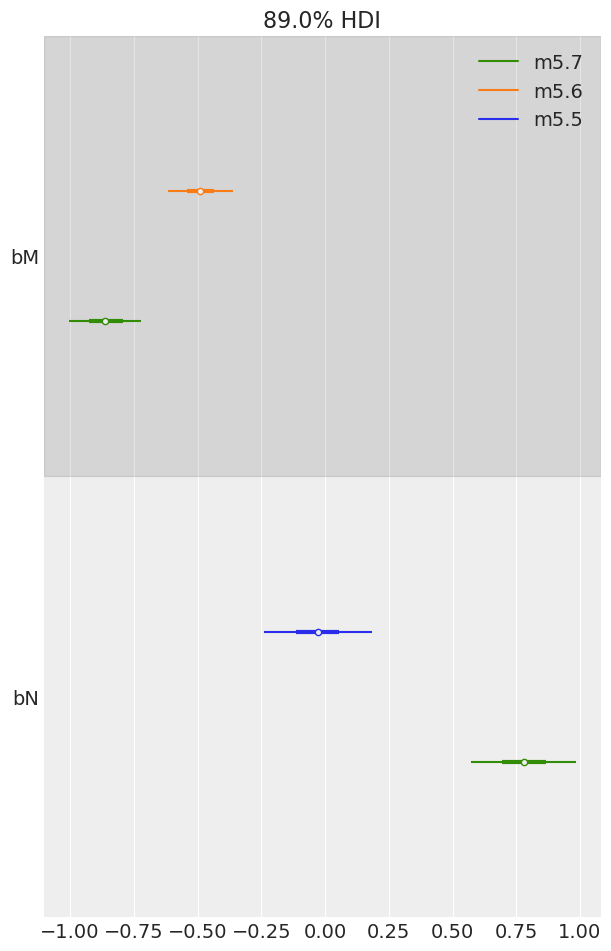

In [118]:
# M -> K <- N
# N -> M
n = 100
N = dist.Normal().sample(random.PRNGKey(0), (n,))
M = dist.Normal(N).sample(random.PRNGKey(1))
K = dist.Normal(N - M).sample(random.PRNGKey(2))
d_sim2 = pd.DataFrame({"K": K, "N": N, "M": M})

#------------------------------------------------------------#

# Recreate m5_5_sim
def model(N, K=None):
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bN = numpyro.sample('bN', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bN * N)
    numpyro.sample('K', dist.Normal(mu, sigma), obs=K)
m5_5_sim = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_5_sim,
    optim.Adam(0.1),
    Trace_ELBO(),
    N=d_sim2.N.values,
    K=d_sim2.K.values
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_5_sim = svi_result.params  

#------------------------------------------------------------#

# Recreate m5_6_sim
def model(M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)
m5_6_sim = AutoLaplaceApproximation(model)
svi = SVI(model, m5_6_sim, optim.Adam(1), Trace_ELBO(), M=d_sim2.M.values, K=d_sim2.K.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_6_sim = svi_result.params

#------------------------------------------------------------#

# Recreate m5_7_sim
def model(N, M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)
m5_7_sim = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_7_sim,
    optim.Adam(1),
    Trace_ELBO(),
    N=d_sim2.N.values,
    M=d_sim2.M.values,
    K=d_sim2.K.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_7_sim = svi_result.params

#------------------------------------------------------------#

# 5.39
coeftab = {
    "m5.5": m5_5_sim.sample_posterior(
        random.PRNGKey(1),
        p5_5_sim,
        (
            1,
            1000,
        ),
    ),
    "m5.6": m5_6_sim.sample_posterior(
        random.PRNGKey(2),
        p5_6_sim,
        (
            1,
            1000,
        ),
    ),
    "m5.7": m5_7_sim.sample_posterior(
        random.PRNGKey(3),
        p5_7_sim,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bM", "bN"],
    hdi_prob=0.89,
)
plt.show()

100%|█| 1000/1000 [00:00<00:00, 6145.55it/s, init loss: 3757.8430, avg. loss [95
100%|█| 1000/1000 [00:00<00:00, 6625.99it/s, init loss: 17295.6777, avg. loss [9
100%|█| 1000/1000 [00:00<00:00, 6015.00it/s, init loss: 2211.3472, avg. loss [95


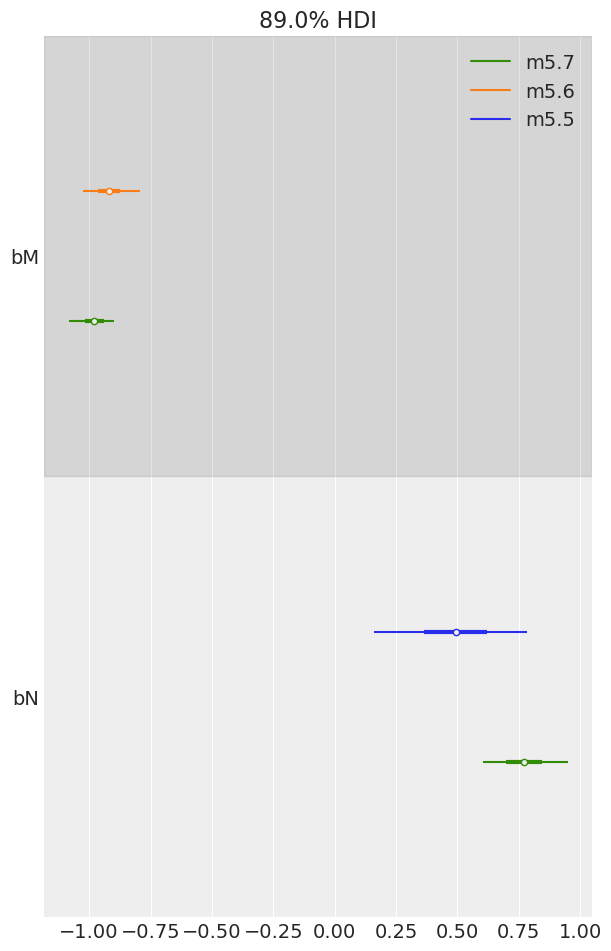

In [119]:
# M -> K <- N
# M <- U -> N
n = 100
N = dist.Normal().sample(random.PRNGKey(3), (n,))
M = dist.Normal(M).sample(random.PRNGKey(4))
K = dist.Normal(N - M).sample(random.PRNGKey(5))
d_sim3 = pd.DataFrame({"K": K, "N": N, "M": M})

#------------------------------------------------------------#

# Recreate m5_5_sim
def model(N, K=None):
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bN = numpyro.sample('bN', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bN * N)
    numpyro.sample('K', dist.Normal(mu, sigma), obs=K)
m5_5_sim = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_5_sim,
    optim.Adam(0.1),
    Trace_ELBO(),
    N=d_sim3.N.values,
    K=d_sim3.K.values
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_5_sim = svi_result.params  

#------------------------------------------------------------#

# Recreate m5_6_sim
def model(M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)
m5_6_sim = AutoLaplaceApproximation(model)
svi = SVI(model, m5_6_sim, optim.Adam(1), Trace_ELBO(), M=d_sim3.M.values, K=d_sim3.K.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_6_sim = svi_result.params

#------------------------------------------------------------#

# Recreate m5_7_sim
def model(N, M, K=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bN * N + bM * M)
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)
m5_7_sim = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_7_sim,
    optim.Adam(1),
    Trace_ELBO(),
    N=d_sim3.N.values,
    M=d_sim3.M.values,
    K=d_sim3.K.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_7_sim = svi_result.params

#------------------------------------------------------------#

# 5.39
coeftab = {
    "m5.5": m5_5_sim.sample_posterior(
        random.PRNGKey(1),
        p5_5_sim,
        (
            1,
            1000,
        ),
    ),
    "m5.6": m5_6_sim.sample_posterior(
        random.PRNGKey(2),
        p5_6_sim,
        (
            1,
            1000,
        ),
    ),
    "m5.7": m5_7_sim.sample_posterior(
        random.PRNGKey(3),
        p5_7_sim,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bM", "bN"],
    hdi_prob=0.89,
)
plt.show()

In [120]:
# 5.43
dag5_7 = CausalGraphicalModel(
    nodes=["M", "K", "N"], edges=[("M", "K"), ("N", "K"), ("M", "N")]
)
coordinates = {"M": (0, 0.5), "K": (1, 1), "N": (2, 0.5)}
nodes = list(dag5_7.dag.nodes.keys())
edges = list(dag5_7.dag.edges.keys())
MElist = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            try:
                new_dag = CausalGraphicalModel(
                    nodes=nodes,
                    edges=[
                        edges[0] if i == 0 else edges[0][::-1],
                        edges[1] if j == 0 else edges[1][::-1],
                        edges[2] if k == 0 else edges[2][::-1],
                    ],
                )
                MElist.append(new_dag)
            except:
                pass

## 5.3 Categorical variables

In [2]:
# 5.45
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
# 5.45
mu_female = dist.Normal(178,20).sample(random.PRNGKey(0), (int(1e4),))
diff = dist.Normal(0,10).sample(random.PRNGKey(1), (int(1e4),))
mu_male = dist.Normal(178,20).sample(random.PRNGKey(3), (int(1e4),)) + diff
print_summary({"mu_female": mu_female, "mu_male": mu_male}, 0.89, False)

I0000 00:00:1702485580.009983       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.



                 mean       std    median      5.5%     94.5%     n_eff     r_hat
  mu_female    178.21     20.22    178.24    147.19    211.84   9943.61      1.00
    mu_male    177.85     22.42    177.96    141.97    212.89   9469.26      1.00



In [4]:
# 5.47
d['sex'] = jnp.where(d.male.values == 1, 1, 0)
d.sex

0      1
1      0
2      0
3      1
4      0
      ..
539    1
540    1
541    0
542    1
543    1
Name: sex, Length: 544, dtype: int32

In [8]:
# 5.47
def model(sex, height):
    a = numpyro.sample("a", dist.Normal(178, 20).expand([len(set(sex))]))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a[sex]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

Using an **indicator variable**

In [9]:
m5_8 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m5_8, optim.Adam(1), Trace_ELBO(), sex=d.sex.values, height=d.height.values
)
svi_result = svi.run(random.PRNGKey(0), 2000)
p5_8 = svi_result.params
post = m5_8.sample_posterior(random.PRNGKey(1), p5_8, (1000,))
print_summary(post, 0.89, False)

100%|█| 2000/2000 [00:00<00:00, 9346.40it/s, init loss: 5607.9023, avg. loss [19



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



In [13]:
# 5.48
post = m5_8.sample_posterior(random.PRNGKey(1), p5_8, (1000,))
post['diff_fm'] = post['a'][:, 0] - post['a'][:, 1]
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
   diff_fm     -7.54      2.38     -7.47    -11.77     -4.32    876.56      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



In [14]:
# 5.49
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

In [16]:
# 5.51
d['clade_id'] = d.clade.astype('category').cat.codes
d.clade_id

0     3
1     3
2     3
3     3
4     3
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    2
15    2
16    2
17    2
18    2
19    2
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
Name: clade_id, dtype: int8

100%|█| 1000/1000 [00:00<00:00, 7357.71it/s, init loss: 94.6847, avg. loss [951-


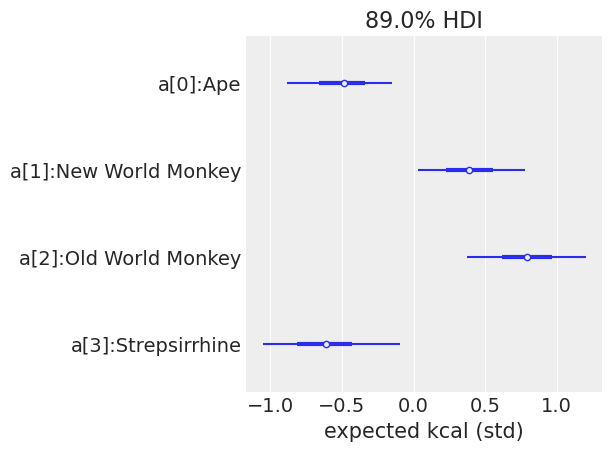

In [23]:
# 5.52
# standardize K (kcal per g)
d['K'] = d['kcal.per.g'].pipe(lambda x: (x - x.mean()) / x.std())

def model(clade_id, K):
    a = numpyro.sample('a', dist.Normal(0, 0.5).expand([len(set(clade_id))]))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a[clade_id]
    numpyro.sample('height', dist.Normal(mu, sigma), obs=K)

m5_9 = AutoLaplaceApproximation(model)
svi = SVI(model,
          m5_9,
          optim.Adam(1),
          Trace_ELBO(),
          clade_id=d.clade_id.values,
          K=d.K.values,
         )
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_9 = svi_result.params
post = m5_9.sample_posterior(random.PRNGKey(1), p5_9, (1000,))

# plot
labels = ["a[" + str(i) + "]:" + s for i, s in enumerate(sorted(d.clade.unique()))]
az.plot_forest({"a": post["a"][None, ...]}, hdi_prob=0.89)
plt.gca().set(yticklabels=labels[::-1], xlabel="expected kcal (std)")
plt.show()

## Exercises